In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras

tf.keras.backend.clear_session()
tf.__version__

TensorFlow 2.x selected.


'2.1.0-rc1'

In [ ]:
class DenseWithFixedBias(keras.layers.Layer):
    def __init__(self, num_outputs, bias = 0):
        super().__init__()
        self.num_outputs = num_outputs
        self.bias = bias

    def build(self, input_shape):
        self.kernel = self.add_weight("kernel",
                                      shape=[int(input_shape[-1]), self.num_outputs])

    def call(self, input):
        return tf.matmul(input, self.kernel) + self.bias

class WeightsHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.weights = []

    def on_batch_end(self, batch, logs={}):
        self.weights.append(self.model.weights[0].numpy().tolist())

In [ ]:
y = np.array([
    .2,
    .8
])
x = np.array([
    (.6, .4),
    (1., .4)
])
x_test = x
y_test = y
x, y

(array([[0.6, 0.4],
        [1. , 0.4]]), array([0.2, 0.8]))

In [ ]:
bias = 0.45
initial_weights = [.1, .0005]

def construct_model():
    model = keras.models.Sequential([
        keras.layers.Input(shape=(2,)),
        DenseWithFixedBias(1, bias)
    ])
    model.weights[0].assign(tf.constant(np.array(initial_weights).reshape((2, 1)).astype(np.float32)))

    return model

def fit(model, loss, epochs=10000):
    weights_history = WeightsHistory()

    model.compile(loss=loss, optimizer="sgd", metrics=["accuracy"])
    history = model.fit(x, y, #tf.squeeze(subgoal),
                        batch_size=len(y),
                        epochs=epochs,
                        callbacks=[weights_history],
                        verbose=0)
    return history, weights_history

In [ ]:
# MSE
mse_model = construct_model()
mse_history, mse_weights_history = fit(mse_model, "mse")

In [ ]:
# Custom algorithm

def get_subgoal(y_initial, y_true, progress: float):
    return y_initial + (y_true - y_initial) * progress

def get_distance_to_line(point, a, b):
    print(point, a, b)
    pa = point - a
    ba = b - a
    t = tf.tensordot(pa, ba, axes=[[0, 1], [1, 0]]) / tf.tensordot(ba, ba, axes=[[0, 1], [1, 0]])
    d = tf.norm(pa - t * ba)
    return d

def fractional_loss(y_initial):
    def loss(y_true, y_pred):
        # calculate goal line:
        #y_true = get_subgoal(y_initial, y_true, .3)
        return keras.losses.mean_squared_error(y_true, y_pred) + get_distance_to_line(y_pred, y_initial, y_true) ** 2
    return loss

model = construct_model()

y_initial = model.predict(x)
subgoal = get_subgoal(y_initial, tf.expand_dims(y, axis=-1), .3)
loss = fractional_loss(y_initial)

history, weights_history = fit(model, loss)

Tensor("dense_with_fixed_bias_3/Identity:0", shape=(None, 1), dtype=float32) [[0.51019996]
 [0.5502    ]] Tensor("dense_with_fixed_bias_3_target:0", shape=(None, None), dtype=float32)
Tensor("sequential_3/dense_with_fixed_bias_3/add:0", shape=(2, 1), dtype=float32) [[0.51019996]
 [0.5502    ]] Tensor("Cast_1:0", shape=(2, 1), dtype=float32)
Tensor("sequential_3/dense_with_fixed_bias_3/add:0", shape=(2, 1), dtype=float32) [[0.51019996]
 [0.5502    ]] Tensor("Cast_1:0", shape=(2, 1), dtype=float32)


In [ ]:
models = [mse_model, model]
histories = [mse_history, history]
weights_histories = [mse_weights_history, weights_history]

Text(0, 0.5, 'Loss')

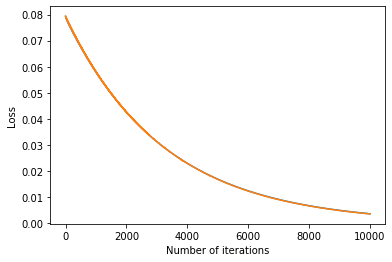

In [ ]:
fig, ax = plt.subplots()
for h in histories:
    ax.plot(h.history["loss"])
ax.set_xlabel("Number of iterations")
ax.set_ylabel("Loss")

In [ ]:
#loss, accuracy = model.evaluate(x, y)
#print(f"Accuracy: {accuracy*100:.0f}%, loss: {loss:.2f}")

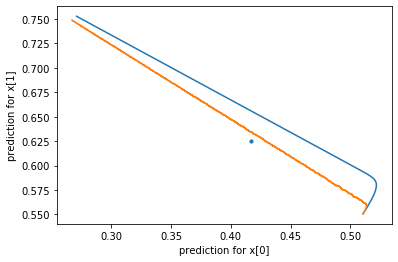

In [ ]:
def predict_with_weights(x, weights):
    return np.matmul(x, weights) + bias

fig, ax = plt.subplots()
for wh in weights_histories:
    ax.plot(*predict_with_weights(x_test, np.array(wh.weights)).T.squeeze())
ax.set_xlabel("prediction for x[0]")
ax.set_ylabel("prediction for x[1]")
ax.scatter(*subgoal, s=10)